# QuantumBlack Hackathon - AI For Good

Binary classifier that predicts presence of methane emissions in an image. Model integrated in a Streamlit Web App for seamless workflows.

***
by: Clara Besnard, Ian Moon, Marina Pellet, Łukasz Pszenny, Adel Remadi, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers building the binary classifier to predict the presence of a methane plume in a given image.

In [ ]:
# if necessary, run installs
%pip install os pandas geopandas shapely reverse_geocoder pycountry

### 1. Import Packages

In [2]:
from importlib import reload
reload(prepData)
reload(loadData)
reload(modeling)
reload(vizData)

<module 'util.visualize_data' from 'C:\\Users\\lasse\\OneDrive\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T3_QuantumBlack AI For Good\\QB-AI-for-Good\\util\\visualize_data.py'>

In [1]:
# import own scripts
import util.preprocess_data as prepData
import util.load_data as loadData
import util.modeling as modeling
import util.visualize_data as vizData

In [2]:
# data handling
import os
import numpy as np
from PIL import Image

# data viz
import matplotlib.pyplot as plt

# modeling
import torch

# hyperparam optimization
from ray import tune

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [4]:
# get transforms
trn_transform, valtst_transform = prepData.get_transform() # to be applied during training
trn_transform_viz, valtst_transform_viz = prepData.get_transform(visualize = True) # to visualize what transform does (without normalization)

In [5]:
# fetch metadata
trnval_metadata = loadData.load_metadata("images/metadata.csv", set = "train")
tst_metadata    = loadData.load_metadata("images/metadata.csv", set = "test")

# perform train validation split
trn_metadata, val_metadata = loadData.trainval_split(trnval_metadata, val_size = 0.2)

# show sizes of datasets
print(f"Size of trainval data: {trnval_metadata.__len__()}")
print(f"Size of training data: {trn_metadata.__len__()}")
print(f"Size of validation data: {val_metadata.__len__()}")
print(f"Size of test data: {tst_metadata.__len__()}")

Size of trainval data: 430
Size of training data: 344
Size of validation data: 86
Size of test data: 0


In [6]:
# get pytorch datasets for visualization
trn_dataset_viz_no_transform = loadData.CustomDataset(trn_metadata, apply_CLAHE = False)
trn_dataset_viz_transform    = loadData.CustomDataset(trn_metadata, transform = trn_transform_viz, resize = True, apply_CLAHE = True)

# get pytorch datasets for modeling
trn_dataset = loadData.CustomDataset(trn_metadata, transform = trn_transform, resize = True, apply_CLAHE = True)
val_dataset = loadData.CustomDataset(val_metadata, transform = valtst_transform, resize = True, apply_CLAHE = True)
tst_dataset = loadData.CustomDataset(tst_metadata, transform = valtst_transform, resize = True, apply_CLAHE = True)

In [7]:
# get mean and std of dataset to identify values by which we need to normalize
trn_dataset.compute_mean_std()

(60.0644191863925, 58.84460681054689)

In [8]:
trn_metadata.plume

0      1
1      1
2      0
3      1
4      1
      ..
339    1
340    1
341    0
342    0
343    1
Name: plume, Length: 344, dtype: int64

images/plume/20230307_methane_mixing_ratio_id_8701.tif
images/plume/20230307_methane_mixing_ratio_id_8701.tif
4096
50176


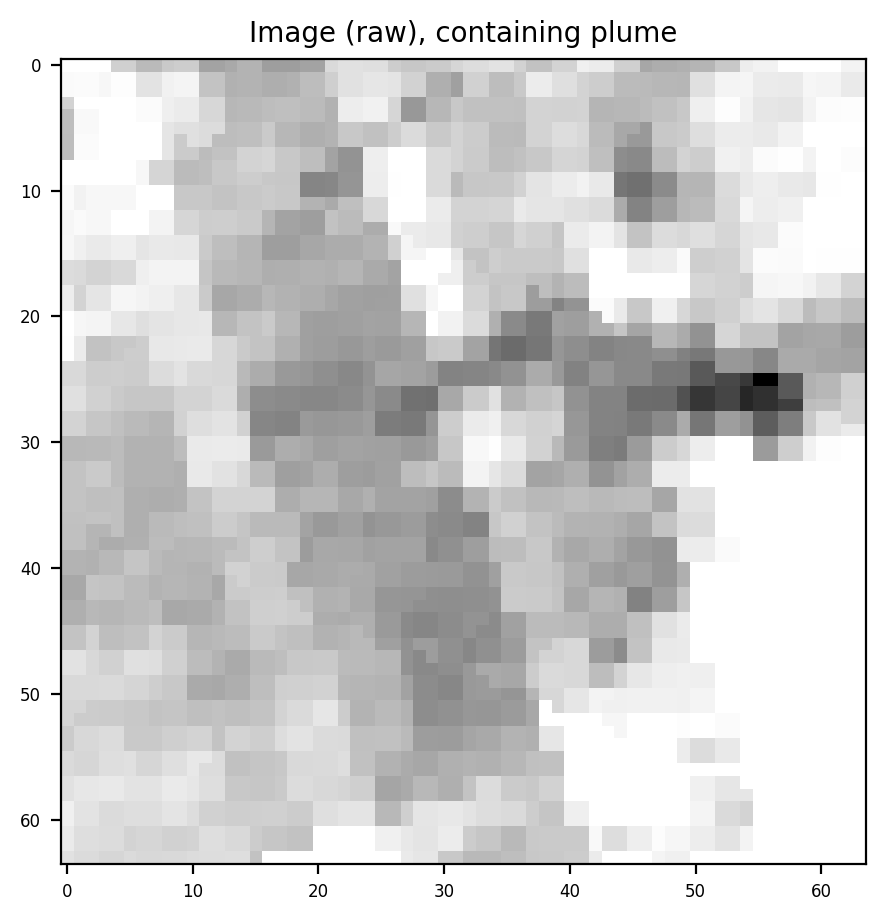

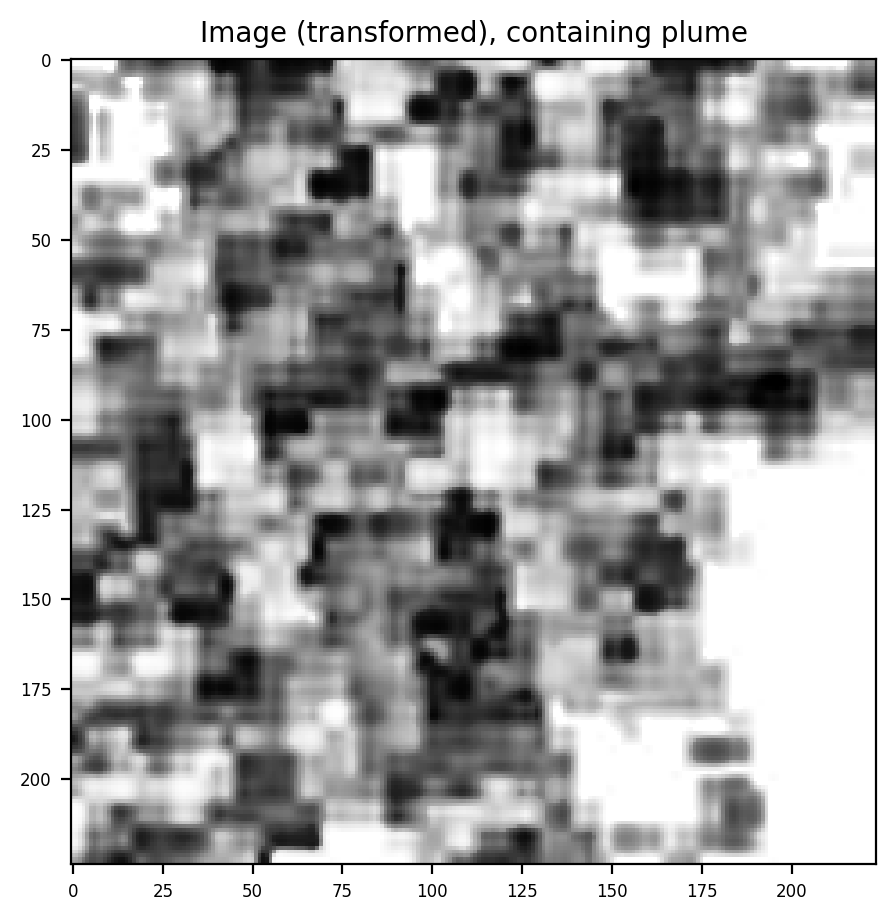

In [9]:
# fetch random image & mask for visualization (training)
idx = 339

# get non-transformed image
_, img, lbl = trn_dataset_viz_no_transform.__getitem__(idx)
path = trn_metadata.loc[idx].path
print(path)

# get transformed image
_, img_tf, _ = trn_dataset_viz_transform.__getitem__(idx)
path = trn_metadata.loc[idx].path
print(path)

# visualize original image (without transformations)
vizData.visualize(img, lbl = lbl)

# visualize transformed image
vizData.visualize(img_tf, lbl = lbl, transform = True)

Ensure that our stratified k-fold train validation test split function works well.

In [10]:
folds, test_df = loadData.stratified_split(trnval_metadata, 3, 0.1)

In [11]:
# show number of samples in each fold
for k, fold in folds.items():
    print(f"fold [{k}/3] -- train {len(fold['train'])}, val {len(fold['val'])}")

fold [0/3] -- train 289, val 121
fold [1/3] -- train 265, val 124
fold [2/3] -- train 287, val 123


In [12]:
fold0_trn = set(folds[0]["train"].id_coord)
fold0_val = set(folds[0]["val"].id_coord)

fold1_trn = set(folds[1]["train"].id_coord)
fold1_val = set(folds[1]["val"].id_coord)

fold2_trn = set(folds[2]["train"].id_coord)
fold2_val = set(folds[2]["val"].id_coord)

In [13]:
fold0_trn

{'id_0080',
 'id_0859',
 'id_1503',
 'id_1988',
 'id_2146',
 'id_2274',
 'id_2384',
 'id_2519',
 'id_2542',
 'id_2708',
 'id_2863',
 'id_2884',
 'id_3130',
 'id_3192',
 'id_3733',
 'id_3773',
 'id_4129',
 'id_4212',
 'id_4690',
 'id_4803',
 'id_4928',
 'id_5045',
 'id_5315',
 'id_5491',
 'id_5654',
 'id_5726',
 'id_5988',
 'id_6084',
 'id_6127',
 'id_6245',
 'id_6426',
 'id_6459',
 'id_6609',
 'id_6658',
 'id_6707',
 'id_6762',
 'id_6912',
 'id_7026',
 'id_7566',
 'id_7964',
 'id_7965',
 'id_8446',
 'id_8701',
 'id_8714',
 'id_8773',
 'id_9028',
 'id_9482',
 'id_9715',
 'id_9857',
 'id_9907',
 'id_9912'}

In [14]:
# ensure that each location is only once across all validation folds
result = {}

for fold in [fold0_val, fold1_val, fold2_val]:
    for id_coord in fold:
        if id_coord not in result:
            result[id_coord] = 1
        else:
            print(f"id_coord {id_coord} in multiple folds!")
            result[id_coord] += 1
result

{'id_3353': 1,
 'id_4287': 1,
 'id_2774': 1,
 'id_8815': 1,
 'id_5497': 1,
 'id_6675': 1,
 'id_6546': 1,
 'id_0471': 1,
 'id_4127': 1,
 'id_1465': 1,
 'id_6464': 1,
 'id_7820': 1,
 'id_6148': 1,
 'id_4456': 1,
 'id_7690': 1,
 'id_2040': 1,
 'id_0438': 1,
 'id_4948': 1,
 'id_6809': 1,
 'id_7467': 1,
 'id_0716': 1,
 'id_4574': 1,
 'id_5510': 1,
 'id_3510': 1,
 'id_4447': 1,
 'id_0041': 1,
 'id_7352': 1,
 'id_0972': 1,
 'id_5988': 1,
 'id_2146': 1,
 'id_6609': 1,
 'id_2384': 1,
 'id_8701': 1,
 'id_9907': 1,
 'id_2863': 1,
 'id_0859': 1,
 'id_9028': 1,
 'id_3773': 1,
 'id_6426': 1,
 'id_9715': 1,
 'id_6127': 1,
 'id_6912': 1,
 'id_7965': 1,
 'id_2708': 1,
 'id_5654': 1,
 'id_4928': 1,
 'id_4690': 1,
 'id_3130': 1,
 'id_7566': 1,
 'id_1503': 1,
 'id_9857': 1,
 'id_2274': 1,
 'id_0080': 1,
 'id_5045': 1,
 'id_6762': 1,
 'id_9482': 1,
 'id_2542': 1,
 'id_3192': 1,
 'id_3733': 1,
 'id_4129': 1,
 'id_9912': 1,
 'id_5726': 1,
 'id_5315': 1,
 'id_7964': 1,
 'id_7026': 1,
 'id_1988': 1,
 'id_8773'

In [15]:
# ensure that each location is represented in every fold
for (trn, val) in [(fold0_trn, fold0_val), (fold1_trn, fold1_val), (fold2_trn, fold2_val)]:
    result = {}
    
    for data in [trn, val]:
        for id_coord in data:
            if id_coord not in result:
                result[id_coord] = 1
            else:
                print(f"id_coord {id_coord} in multiple folds!")
                result[id_coord] += 1
    
    if len(result) != 101 - len(test_df.id_coord.unique()):
        print("locations are missing")

In [16]:
len(result)

79

### 3. Modeling

Learnings:
- for Resnet18 and 34, pre-trained models do not seem to work well (maybe because we needed to change first convolution because input images have only one channel and not three -- so we lost all pre-trained weights for first convolution)
- Resnet18 same performance level as ResNet34, maybe even slightly better --> no need to use ResNet34 then (overly complex)
- batch size of 16 better than 8 and 4 for ResNets --> maybe try out even bigger batches
- higher number of epoch better (50 worked well, 20 ok, 10 too low)

#### 3.1 Train a Single Model

Let us validate that our implementation is correct by running one training loop.

In [17]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # basic infos
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": True,
    "save": True,
    
    # k-fold cross val settings
    "artificial_test_size": 0.0,
    "k_cv": 5, # must be bigger than 1
    "prediction_strategy": "avg", # ["avg", "max"]
    
    # test set settings
    "official_test": False,
    
    # model settings
    "model": "mobilenet_v3_large",
    "max_epochs": 50,
    "batch_size": 16,
    
    # classifier settings
    "classifier": "shallow",
    "width": 512,
    "depth": 2,
    
    # preprocessing
    "resize": True, # resize images from (64, 64) to (224, 224)
    "apply_CLAHE": False, # improve image contrast
    
    # scheduler
    "lr_s": "Cosine", # StepLR decreases learning rate every 10 epochs by factor of 10
    
    # optimizer
    "optim_name": "AdamW",
    "lr":   2e-3,
    "wd":   1e-2,
    "mom":  0.9, # only for SGD
    
    # loss function
    "criterion": "BCE"
}

In [18]:
# ensure reproducibility (for meaningful hyperparameter selection that does not depend on random seed behavior)
modeling.set_reproducible()

# initialise objects for training
trnloaders, valloaders, tstloader = modeling.init_data(config)

# validate
print(len(tstloader.dataset))

0


In [19]:
# validate test data
for id_coord in sorted(tstloader.dataset.metadata.id_coord.unique()):
    print(id_coord, len(tstloader.dataset.metadata.loc[tstloader.dataset.metadata.id_coord == id_coord]))

In [20]:
# perform training (no return!)
modeling.train_evaluate_model(config, trnloaders, valloaders, tstloader,
                              verbose = config["verbose"], ray = False, return_obj = False)

We have started training
Starting fold [1/5]
Fold [1/5], Epoch [1/50] --> Trn Loss: 0.69, Val Loss: 0.72, Trn AUC: 0.651, Val AUC: 0.64
Fold [1/5], Epoch [2/50] --> Trn Loss: 0.69, Val Loss: 0.73, Trn AUC: 0.62, Val AUC: 0.577
Fold [1/5], Epoch [3/50] --> Trn Loss: 0.68, Val Loss: 0.83, Trn AUC: 0.63, Val AUC: 0.536
Fold [1/5], Epoch [4/50] --> Trn Loss: 0.6, Val Loss: 0.72, Trn AUC: 0.747, Val AUC: 0.565
Fold [1/5], Epoch [5/50] --> Trn Loss: 0.65, Val Loss: 0.62, Trn AUC: 0.667, Val AUC: 0.374
Fold [1/5], Epoch [6/50] --> Trn Loss: 0.6, Val Loss: 0.65, Trn AUC: 0.736, Val AUC: 0.589
Fold [1/5], Epoch [7/50] --> Trn Loss: 0.61, Val Loss: 0.69, Trn AUC: 0.735, Val AUC: 0.588
Fold [1/5], Epoch [8/50] --> Trn Loss: 0.54, Val Loss: 0.68, Trn AUC: 0.797, Val AUC: 0.617
Fold [1/5], Epoch [9/50] --> Trn Loss: 0.57, Val Loss: 0.64, Trn AUC: 0.774, Val AUC: 0.593
Fold [1/5], Epoch [10/50] --> Trn Loss: 0.53, Val Loss: 0.71, Trn AUC: 0.805, Val AUC: 0.579
Fold [1/5], Epoch [11/50] --> Trn Loss:

Fold [2/5], Epoch [39/50] --> Trn Loss: 0.48, Val Loss: 0.54, Trn AUC: 0.848, Val AUC: 0.905
Fold [2/5], Epoch [40/50] --> Trn Loss: 0.51, Val Loss: 0.53, Trn AUC: 0.812, Val AUC: 0.898
Fold [2/5], Epoch [41/50] --> Trn Loss: 0.51, Val Loss: 0.54, Trn AUC: 0.836, Val AUC: 0.9
Fold [2/5], Epoch [42/50] --> Trn Loss: 0.47, Val Loss: 0.52, Trn AUC: 0.853, Val AUC: 0.895
Fold [2/5], Epoch [43/50] --> Trn Loss: 0.48, Val Loss: 0.52, Trn AUC: 0.835, Val AUC: 0.899
Fold [2/5], Epoch [44/50] --> Trn Loss: 0.44, Val Loss: 0.5, Trn AUC: 0.872, Val AUC: 0.899
Fold [2/5], Epoch [45/50] --> Trn Loss: 0.42, Val Loss: 0.49, Trn AUC: 0.883, Val AUC: 0.902
Fold [2/5], Epoch [46/50] --> Trn Loss: 0.51, Val Loss: 0.5, Trn AUC: 0.85, Val AUC: 0.902
Fold [2/5], Epoch [47/50] --> Trn Loss: 0.49, Val Loss: 0.5, Trn AUC: 0.847, Val AUC: 0.902
Fold [2/5], Epoch [48/50] --> Trn Loss: 0.51, Val Loss: 0.5, Trn AUC: 0.834, Val AUC: 0.903
Fold [2/5], Epoch [49/50] --> Trn Loss: 0.44, Val Loss: 0.51, Trn AUC: 0.878,

Fold [4/5], Epoch [28/50] --> Trn Loss: 0.46, Val Loss: 0.38, Trn AUC: 0.85, Val AUC: 0.807
Fold [4/5], Epoch [29/50] --> Trn Loss: 0.42, Val Loss: 0.29, Trn AUC: 0.879, Val AUC: 0.898
Fold [4/5], Epoch [30/50] --> Trn Loss: 0.46, Val Loss: 0.36, Trn AUC: 0.844, Val AUC: 0.864
Fold [4/5], Epoch [31/50] --> Trn Loss: 0.48, Val Loss: 0.62, Trn AUC: 0.833, Val AUC: 0.855
Fold [4/5], Epoch [32/50] --> Trn Loss: 0.41, Val Loss: 0.42, Trn AUC: 0.885, Val AUC: 0.869
Fold [4/5], Epoch [33/50] --> Trn Loss: 0.5, Val Loss: 0.48, Trn AUC: 0.82, Val AUC: 0.85
Fold [4/5], Epoch [34/50] --> Trn Loss: 0.45, Val Loss: 0.38, Trn AUC: 0.869, Val AUC: 0.86
Fold [4/5], Epoch [35/50] --> Trn Loss: 0.39, Val Loss: 0.33, Trn AUC: 0.888, Val AUC: 0.876
Fold [4/5], Epoch [36/50] --> Trn Loss: 0.41, Val Loss: 0.36, Trn AUC: 0.876, Val AUC: 0.892
Fold [4/5], Epoch [37/50] --> Trn Loss: 0.4, Val Loss: 0.39, Trn AUC: 0.872, Val AUC: 0.895
Fold [4/5], Epoch [38/50] --> Trn Loss: 0.39, Val Loss: 0.45, Trn AUC: 0.888

#### 3.2 Hyperparameter Tuning

In [4]:
# where to save trial results to
ray_path = os.path.normpath(os.getcwd()).replace("\\", "/") +"/ray_results/"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

# ignore warnings that show in every raytune run
import warnings
warnings.simplefilter(action = "ignore", category = np.VisibleDeprecationWarning)

In [5]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # basic infos
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": False,
    "save": True,
    
    # k-fold cross val settings
    "artificial_test_size": 0.15,
    "k_cv": 5, # must be bigger than 1
    "prediction_strategy": "avg", # ["avg", "max"]
    
    # test set settings
    "official_test": False,
    
    # model settings
    "model": tune.grid_search(["mobilenet_v3_small", "mobilenet_v3_large", "densenet121", "densenet161"]),
    "max_epochs": 50,
    "batch_size": 16,
    
    # classifier settings
    "classifier": "shallow",
    "width": 512,
    "depth": 2,
    
    # preprocessing
    "resize": True, # resize images from (64, 64) to (224, 224)
    "apply_CLAHE": False, # improve image contrast
    
    # scheduler
    "lr_s": "Cosine", # StepLR decreases learning rate every 10 epochs by factor of 10
    
    # optimizer
    "optim_name": tune.grid_search(["AdamW", "SGD"]),
    "lr":   tune.grid_search([1e-2, 5e-3, 1e-3]),
    "wd":   1e-2,
    "mom":  0.9, # only for SGD
    
    # loss function
    "criterion": "BCE"
}

In [ ]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = modeling.run_ray_experiment(
    modeling.ray_trainable, config, ray_path, num_samples,
    metric_columns = ["trn_auc", "val_auc", "test_auc"],
    parameter_columns = ["model", "optim_name", "lr", "wd"]
)

2023-05-16 04:30:46,872	INFO worker.py:1553 -- Started a local Ray instance.


**Analyze RayTune experiment.**

In [6]:
restored_tuner, result_grid = modeling.open_validate_ray_experiment("ray_results/3_grid_stratkcv_densenet_mobilenet", modeling.ray_trainable)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Loading results from ray_results/3_grid_stratkcv_densenet_mobilenet...
Done!

No errors! Number of terminated trials: 24


In [9]:
# get best N trials in this experiment (highest validation accuracy [averaged across 4 folds])
N = 20
best_result_df = result_grid.get_dataframe(
    filter_metric="val_auc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id",
                                 "config/max_epochs", "config/batch_size",
                                 "config/model", # "config/prediction_strategy",
                                 #"config/apply_CLAHE", "config/resize",
                                 "config/optim_name", "config/lr", "config/wd", # "config/lr_s", "config/mom", 
                                 "trn_auc", "val_auc", "test_auc"]]

best_result_df = best_result_df.sort_values(by=["val_auc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

Couldn't read config from 11 paths


,trial_id,config/max_epochs,config/batch_size,config/model,config/optim_name,config/lr,config/wd,trn_auc,val_auc,test_auc
5,aae81_00005,50,16,mobilenet_v3_large,AdamW,0.001,0.01,0.911612,0.919403,0.892628
1,aae81_00001,50,16,mobilenet_v3_small,AdamW,0.005,0.01,0.875575,0.916898,0.894231
0,aae81_00000,50,16,mobilenet_v3_small,AdamW,0.010,0.01,0.867821,0.913720,0.889423
8,aae81_00008,50,16,densenet121,AdamW,0.001,0.01,0.878296,0.904038,0.873397
4,aae81_00004,50,16,mobilenet_v3_large,AdamW,0.005,0.01,0.868418,0.901215,0.876603
2,aae81_00002,50,16,mobilenet_v3_small,AdamW,0.001,0.01,0.899526,0.897594,0.913462
7,aae81_00007,50,16,densenet121,AdamW,0.005,0.01,0.844306,0.895734,0.850962
3,aae81_00003,50,16,mobilenet_v3_large,AdamW,0.010,0.01,0.861040,0.887928,0.858974
9,aae81_00009,50,16,densenet161,AdamW,0.010,0.01,0.835529,0.878305,0.858974
6,aae81_00006,50,16,densenet121,AdamW,0.010,0.01,0.847704,0.878069,0.871795


**Load best model for inference**

In [17]:
config = {
    # basic infos
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": True,
    "save": True,
    
    # k-fold cross val settings
    "artificial_test_size": 0.2,
    "k_cv": 3, # must be bigger than 1
    
    # test set settings
    "official_test": False,
    
    # model settings
    "max_epochs": 50,
    "batch_size": 16,
    
    # preprocessing
    "resize": True, # resize images from (64, 64) to (224, 224)
    "apply_CLAHE": False, # improve image contrast
    
    # model
    "model": "ResNet34",
    "pretrained": False,
    
    # scheduler
    "lr_s": "Cosine", # StepLR decreases learning rate every 10 epochs by factor of 10
    
    # optimizer
    "lr":   1e-2,
    "wd":   1e-2,
    "mom":  0.9,
    
    # loss function
    "criterion": "BCE"
}

In [18]:
(model, optimizer, trnloader, valloader, tstloader, scheduler, scheduler_step, criterion, device) = modeling.init_training(config)

In [19]:
path = "models/best_ResNet34.pt"
model.load_state_dict(torch.load(path))
model.eval()
print("")

In [31]:
modeling.test_epoch(valloader, model, criterion, device)

(0.9302325581395349, 0.9820728291316526, 0.1945905089378357)